# Mat 258A HW 7
Lasso Optimization with Subgradient Method and ISTA

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import time
np.seterr(all='ignore')

m = 100
n = 500
s = 2

A = np.random.standard_normal((m, n))
xs = np.zeros((n, 1))
picks = np.random.choice(n, s, replace=False)
xs[picks] = np.random.standard_normal((s, 1))
b = A @ xs

In [3]:
def lasso_obj(A: np.ndarray, b: np.ndarray, x: np.ndarray, tau: float) -> float:
    return np.linalg.norm(A @ x - b)**2 + tau * np.linalg.norm(x, 1)

def lasso_subgradient(A, b, x, tau):
    """
    Compute a subgradient of the Lasso loss function.

    Args:
        A (np.ndarray): The design matrix of shape (m, n).
        b (np.ndarray): The response vector of shape (m, 1).
        x (np.ndarray): The current iterate (n, 1).
        tau (float): The regularization parameter.
    Returns:
        np.ndarray: The subgradient of the Lasso loss function at xs.
    """

    grad = 2 * A.T @ (A @ x - b)
    subgrad = grad + tau * np.sign(x)
    return subgrad

In [4]:
import numpy as np
import matplotlib.pyplot as plt
from typing import List, Dict, Tuple

def plot_runs(runs: List[Dict],
                 A: np.ndarray,
                 b: np.ndarray,
                 xs: np.ndarray,
                 title: str = "A Title for the Plots"):
    """
    Draw two figures – cumulative CPU time and objective error –
    for several stored runs of the sub‑gradient method.

    Parameters
    ----------
    runs : list of dict
        Each element is exactly the dictionary returned by `sg_method_solve`.
    A, b : np.ndarray
        Design matrix and response vector (needed for objective values).
    xs : np.ndarray
        Exact solution (ground truth).
    """
    # Figure 1: objective value relative error vs cumulative CPU time
    plt.figure()
    for run in runs:
        tau, eps, times, f_err = run["tau"], run["eps"], run["times"], run["f_err"]
        f_rel_err = f_err / lasso_obj(A, b, xs, tau)
        plt.semilogy(times, f_rel_err,
                     label=rf"$\tau={tau:.1e},\ \varepsilon={eps:.0e}$")
    plt.xlabel("Time (s)")
    plt.ylabel(r"$(f(x_k)-f(xs))/f(xs)$")
    plt.title(f"{title}: obj rel error vs time")
    plt.legend()
    plt.grid(True)
    plt.show()

    # Figure 2: objective value relative error vs iterations
    plt.figure()
    for run in runs:
        tau, eps, f_err = run["tau"], run["eps"], run["f_err"]
        f_rel_err = f_err / lasso_obj(A, b, xs, tau)
        plt.semilogy(np.arange(len(f_err)), f_rel_err,
                     label=rf"$\tau={tau:.1e},\ \varepsilon={eps:.0e}$")
    plt.xlabel("Iteration $k$")
    plt.ylabel(r"$(f(x_k)-f(xs))/f(xs)$")
    plt.title(f"{title}: obj rel error vs iteration")
    plt.legend()
    plt.grid(True)
    plt.show()

    # Figure 3: relative error vs cumulative CPU time
    plt.figure()
    for run in runs:
        tau, eps, times, x_err = run["tau"], run["eps"], run["times"], run["x_rel_error"]
        plt.semilogy(times, x_err,
                     label=rf"$\tau={tau:.1e},\ \varepsilon={eps:.0e}$")
    plt.xlabel("Time (s)")
    plt.ylabel("|xk - xs|/|xs| Relative Error")
    plt.title(f"{title}: xk rel error vs time")
    plt.legend()
    plt.grid(True)
    plt.show()

    # Figure 4: relative error vs iterations
    plt.figure()
    for run in runs:
        tau, eps, x_err = run["tau"], run["eps"], run["x_rel_error"]
        plt.semilogy(np.arange(len(x_err)), x_err,
                     label=rf"$\tau={tau:.1e},\ \varepsilon={eps:.0e}$")
    plt.xlabel("Iteration $k$")
    plt.ylabel("|xk - xs|/|xs| Relative Error")
    plt.title(f"{title}: xk rel error vs iteration")
    plt.legend()
    plt.grid(True)
    plt.show()

## Subgradient Method
Choosing optimal step sizes based on the knowledge of the global minimum makes it so that xs converges.

In [5]:
def sg_method_solve(A, b, x0, xs, tau, max_iter=100000, tol=1e-6):
    """
    Solve the Lasso problem using the subgradient method.

    Args:
        A (np.ndarray): The design matrix of shape (m, n).
        b (np.ndarray): The response vector of shape (m, 1).
        x0 (np.ndarray): Initial guess for the solution.
        xs (np.ndarray): True solution for comparison.
        tau (float): Regularization parameter.
        max_iter (int): Maximum number of iterations.
        tol (float): Tolerance for convergence.
    Returns:
        dict: A dictionary containing the solution, time taken, number of iterations, tau, and tolerance.
    """

    x = x0.copy()
    x_ks = []
    times = []

    time_s = time.time()

    for k in range(1, max_iter + 1):
        subgrad = lasso_subgradient(A, b, x, tau)
        t = (lasso_obj(A, b, x, tau) - lasso_obj(A, b, xs, tau)) / np.linalg.norm(subgrad)**2
        # t = 1 / k

        x = x - t * subgrad  # Step size is fixed here

        if k % 10000 == 0:
            print(f"Iteration {k}, norm={np.linalg.norm(x - xs)/np.linalg.norm(xs):.4e}")

        if np.linalg.norm(x - xs)/np.linalg.norm(xs) < tol:
            x_ks.append(x)
            times.append(time.time() - time_s)
            break

        x_ks.append(x)
        times.append(time.time() - time_s)
    
    x_rel_err = [np.linalg.norm(xk - xs) / np.linalg.norm(xs) for xk in x_ks]
    f_xks = [lasso_obj(A, b, xk, tau) for xk in x_ks]
    f_err = [lasso_obj(A, b, xk, tau) - lasso_obj(A, b, xs, tau) for xk in x_ks]

    return {
        "x_ks": x_ks,
        "x_rel_error": x_rel_err,
        "f_xks": f_xks,
        "f_err": f_err,
        "times": times,
        "iters": k,
        "tau": tau,
        "eps": tol
    }

Iteration 10000, norm=6.2517e-03


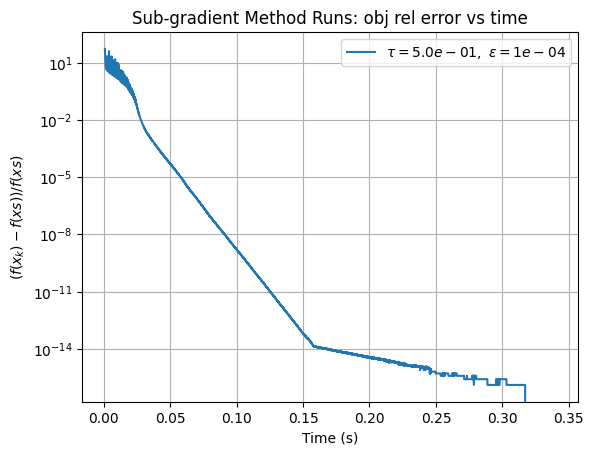

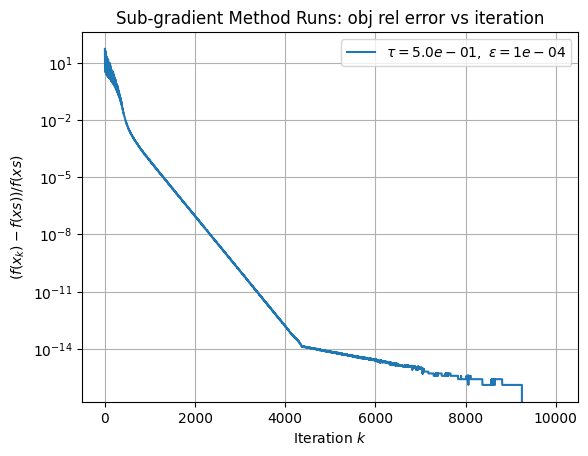

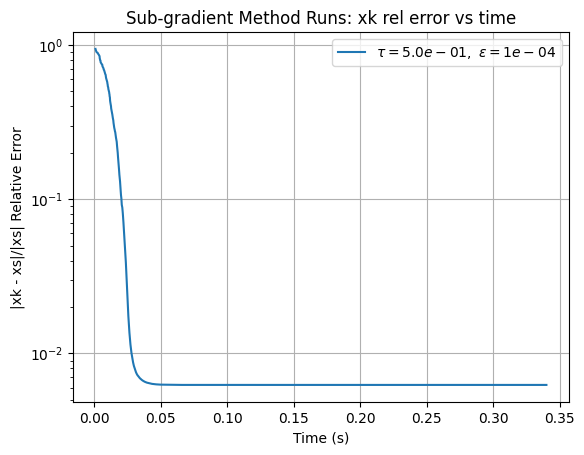

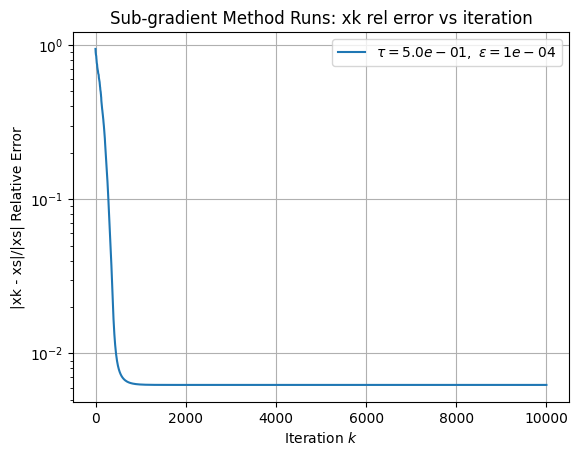

In [11]:
def run_sg_grid_and_plot(A: np.ndarray,
                      b: np.ndarray,
                      x0: np.ndarray,
                      xs: np.ndarray,
                      params: List[Tuple[float, float]],
                      max_iter: int = 10000):
    all_runs = []
    for (tau, eps) in params:
            result = sg_method_solve(A, b, x0, xs,
                                     tau=tau,
                                     max_iter=max_iter,
                                     tol=eps)
            all_runs.append(result)
    plot_runs(all_runs, A, b, xs, title="Sub-gradient Method Runs")

# taus = [1e-2, 1e-1]
# epsilons = [1e-2, 1e-4, 1e-6]
# params = [(1, 1e-2), (1, 1e-4), (1, 1e-6), (0.1, 1e-2), (0.1, 1e-4)]
params = [(0.5, 1e-4)]
x0 = np.zeros((n, 1))

run_sg_grid_and_plot(A, b, x0, xs, params)

## ISTA Method

For ISTA, it seems hard to get convergence beyond $\varepsilon = 10^{-2}$. It is possible to get convergence $\varepsilon = 10^{-4}$ when $\tau = .005$. This is implemented with a fixed step size.

In [7]:
def within_tol_check(x_k, xs, tol, noise=10e-15):
    # Convert to 1D for norm calculations
    x_k = np.asarray(x_k)
    xs = np.asarray(xs)
    error = np.linalg.norm(x_k - xs, 2) / (np.linalg.norm(xs, 2) + noise)
    return error < tol, error

def soft_threshold(u, thresh): 
    return np.sign(u) * np.maximum(np.abs(u) - thresh, 0)

def ista_method_solve(A, b, x0, xs, tau=1, max_iter=100000, tol=1e-6):
    x = x0.copy()

    x_ks = []
    times = []

    time_s = time.time()

    L = 2 * np.linalg.norm(A, 2)**2
    step_size = 1/L

    for k in range(1, max_iter + 1):
        grad = 2 * A.T @ (A@x - b)

        x = soft_threshold(x - step_size * grad, tau * step_size)
        
        done, error = within_tol_check(x, xs, tol)
        x_ks.append(x)
        times.append(time.time() - time_s)

        if done: 
            elapsed_time = time.time() - time_s
            print(f"[tol={tol:.0e}] Converged in {k} iterations ({elapsed_time:.2f} s). Final error: {error:.2e}")
            break
    else: 
        print(f"[tol={tol:.0e}] Did not converge in {max_iter} iterations.")

    x_rel_err = [np.linalg.norm(xk - xs) / np.linalg.norm(xs) for xk in x_ks]
    f_xks = [lasso_obj(A, b, xk, tau) for xk in x_ks]
    f_err = [lasso_obj(A, b, xk, tau) - lasso_obj(A, b, xs, tau) for xk in x_ks]
    
    return {
        "x_ks": x_ks,
        "x_rel_error": x_rel_err,
        "f_xks": f_xks,
        "f_err": f_err,
        "times": times,
        "iters": k,
        "tau": tau,
        "eps": tol,
    }

[tol=1e-04] Did not converge in 1000000 iterations.


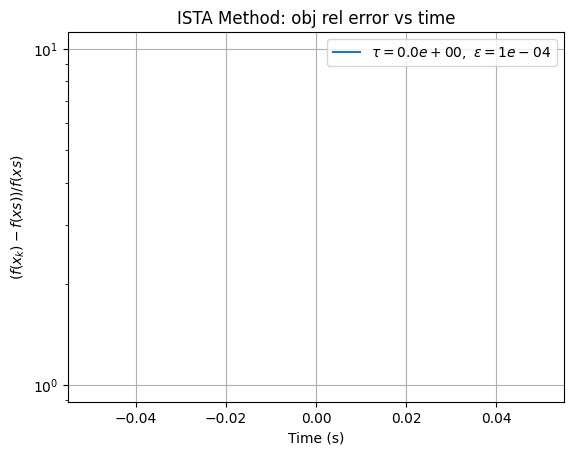

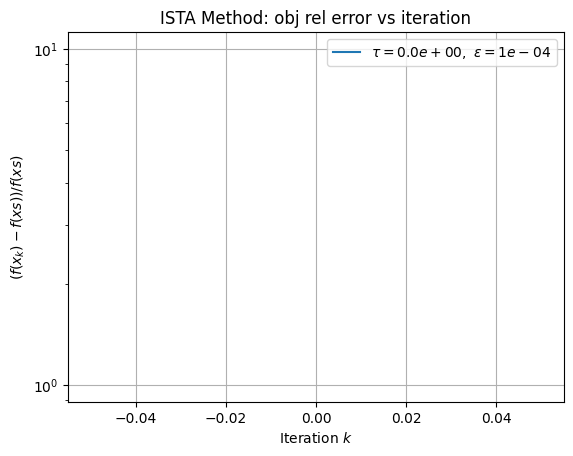

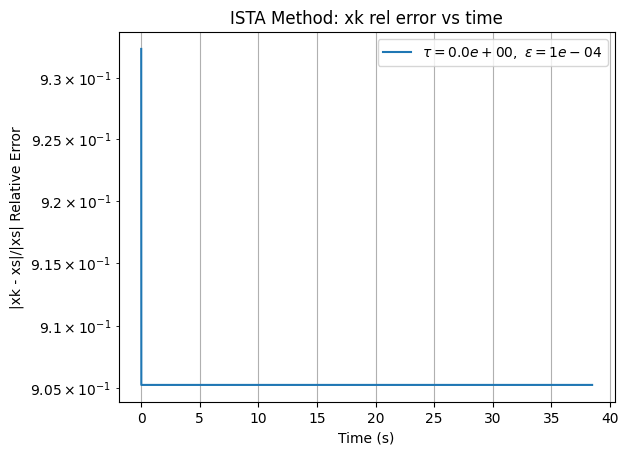

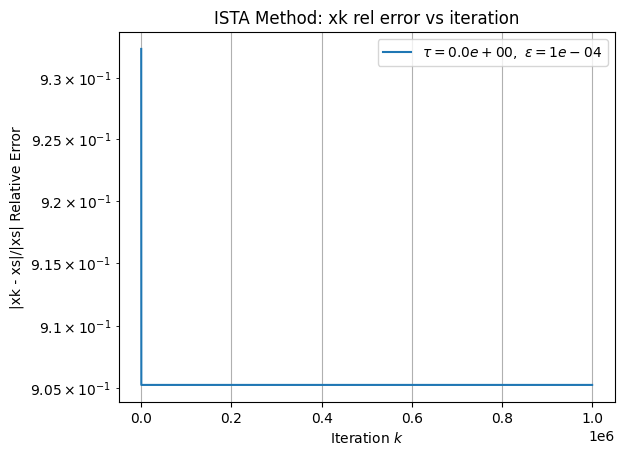

In [ ]:
def run_ista_grid_and_plot(A: np.ndarray,
                      b: np.ndarray,
                      x0: np.ndarray,
                      xs: np.ndarray,
                      params: List[Tuple[float, float]],
                      max_iter: int = 1000000):
    all_runs = []
    for (tau, eps) in params:
            result = ista_method_solve(A, b, x0, xs,
                                     tau=tau,
                                     tol=eps,
                                     max_iter=max_iter,
                                     )
            all_runs.append(result)
    plot_runs(all_runs, A, b, xs, title="ISTA Method")

# params = [(1, 1e-2), (1, 1e-4), (1, 1e-6), (0.1, 1e-2), (0.1, 1e-4), (.005, 1e-4), (0.005, 1e-6)]
params = [(10, 1e-4)]
x0 = np.zeros((n, 1))

run_ista_grid_and_plot(A, b, x0, xs, params)